#**Машинное обучение ИБ-2024**

#**Домашнее задание 1.**
#Регрессия, KNN, LinearRegression.

В данной домашней работе мы будем строить модели для предсказания цены квартиры в России. Ниже приведено описание некоторых колонок набора данных.

date - дата публикации объявления

price - цена в рублях

level- этаж, на котором находится квартира

levels - количество этажей в квартире

rooms - количество комнат в квартире. Если значение -1, то квартира считается апартаментами.

area - площадь квартиры.

kitchen_area - площадь кухни.

geo_lat - Latitude

geo_lon - Longitude

building_type - материал застройки. 0 - Don't know. 1 - Other. 2 - Panel. 3 - Monolithic. 4 - Brick. 5 - Blocky. 6 - Wooden

#Часть 0. Начало работы

Для начала работы с данными импортируем библиотеки, которые понадобятся в данном задании.

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib as plt
import sklearn
import seaborn as sns

Загрузим библиотеку folium для отображения данных на карте по координатам.

In [2]:
!pip install folium

Распакуем наши данные из архива.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip 'drive/MyDrive/data.zip' -d data

Archive:  drive/MyDrive/data.zip
  inflating: data/input_data.csv     


Загрузим данные из csv файла в датафрейм.

In [5]:
dff=pd.read_csv('data/input_data.csv', sep = ';')

In [6]:
dff.head(5)

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
0,2021-01-01,2451300,15,31,1,30.3,0.0,56.780112,60.699355,0,2,620000.0,NaN,66,1632918.0
1,2021-01-01,1450000,5,5,1,33.0,6.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
2,2021-01-01,10700000,4,13,3,85.0,12.0,55.540060,37.725112,3,0,142701.0,242543.0,50,681306.0
3,2021-01-01,3100000,3,5,3,82.0,9.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
4,2021-01-01,2500000,2,3,1,30.0,9.0,44.738685,37.713668,3,2,353960.0,439378.0,23,1730985.0


Так как данных очень много, я уменьшу датасет до первых 5 тысяч строк (с разрешения преподавателя). До этого я сидел 103 минуты ждал предсказания.

In [7]:
df=dff.head(5000)

Отобразим на карте координаты наших построек.

In [8]:
import folium
from IPython.display import display

map_df = df.loc[:1000]

m = folium.Map(location=[55.751244, 37.618423], zoom_start=10)

# Список точек с широтой и долготой
lats = map_df['geo_lat'].loc[:1000]
longs = map_df['geo_lon'].loc[:1000]
# Добавляем точки на карту
for point in zip(lats, longs):
    folium.Marker(
        location=[point[0], point[1]]
    ).add_to(m)

display(m)

# Часть 1. Подготовим данные для обработки моделями машинного обучения.

**0.5 Балл**. География наших наблюдений в наборе данных крайне большая. Однако мы знаем, что стоимость квартир в Москве и Санкт-Петербурге намного выше, чем в среднем по России. Давайте сделаем признаки, который показывают, находится ли квартира в 20 килиметрах от центра Москвы или находится ли квартира в 20 килиметрах от центра Санкт-Петербурга.

Создайте два признака is_Moscow и is_Saint_Peterburg. Для нахождения расстояния по координатам используйте функцию haversine_distance.

In [9]:
def haversine_distance(lat1, lon1, lat2, lon2):
    D=2*np.arcsin(np.sqrt(np.sin((np.radians(lat1)-(np.radians(lat2)))/2)**2+np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*np.sin((np.radians(lon1)-np.radians(lon2))/2)**2))
    return D

Формула из доки Sklearn:

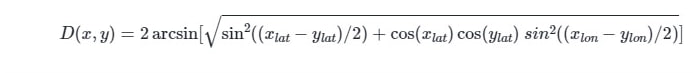

In [10]:
msc_lat=55.751244
msc_lon=37.618423
spb_lat=59.937500
spb_lon=30.308611

Чтобы получить расстояние в КМ, нужно умножить полученное значение на радиус Земли.

In [11]:
earth_radius=6371

In [12]:
df['is_Moscow'] = (df.apply(lambda row: haversine_distance(msc_lat, msc_lon, row['geo_lat'], row['geo_lon'])*earth_radius, axis=1) <= 20).astype(int)
df['is_Saint_Petersburg'] = (df.apply(lambda row: haversine_distance(spb_lat, spb_lon, row['geo_lat'], row['geo_lon'])*earth_radius, axis=1) <= 20).astype(int)

<ipython-input-12-d44e5b9a6f10>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_Moscow'] = (df.apply(lambda row: haversine_distance(msc_lat, msc_lon, row['geo_lat'], row['geo_lon'])*earth_radius, axis=1) <= 20).astype(int)
<ipython-input-12-d44e5b9a6f10>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_Saint_Petersburg'] = (df.apply(lambda row: haversine_distance(spb_lat, spb_lon, row['geo_lat'], row['geo_lon'])*earth_radius, axis=1) <= 20).astype(int)


**0.5 Балла**. В нашем наборе данных есть признаки, которые мы теоретически можем использовать, например postal_code, но мы это будем делать в рамках домашней работы очень-очень долго. Поэтому предлагается удалить ненужные признаки из датафрейма.

Удалим geo_lat,	geo_lon,	object_type,	postal_code,	street_id,	id_region,	house_id.

In [13]:
df=df.drop(['geo_lat', 'geo_lon','object_type', 'postal_code', 'street_id', 'id_region', 'house_id'],axis=1)
df.head(5)

,date,price,level,levels,rooms,area,kitchen_area,building_type,is_Moscow,is_Saint_Petersburg
0,2021-01-01,2451300,15,31,1,30.3,0.0,0,0,0
1,2021-01-01,1450000,5,5,1,33.0,6.0,0,0,0
2,2021-01-01,10700000,4,13,3,85.0,12.0,3,0,0
3,2021-01-01,3100000,3,5,3,82.0,9.0,0,0,0
4,2021-01-01,2500000,2,3,1,30.0,9.0,3,0,0


**0.5 Балл**. Для начала Вам предлагается проанализировать Ваши оставшиеся признаки (колонки) в наборе данных. Какие колонки категориальные? Какие числовые?

Категориальные: ('is_Moscow', 'is_Saint_Petersburg', 'building_type','rooms')

Числовые: ('price','level','rooms','area','kitchen_area')

Давайте закодируем категориальные признаки с помощью OneHot-Encoding. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [14]:
from sklearn.preprocessing import OneHotEncoder

In [15]:
encoder = OneHotEncoder()

df_building = pd.DataFrame(encoder.fit_transform(df[['building_type']]).toarray())

df_building.columns = [f'building_type_{i}' for i in range(df_building.shape[1])]

df_rooms = pd.DataFrame(encoder.fit_transform(df[['rooms']]).toarray())

df_rooms.columns = [f'rooms_{i}' for i in range(df_rooms.shape[1])]

print(df_building.head(5))

print(df_rooms.head(5))

   building_type_0  building_type_1  building_type_2  building_type_3  \
0              1.0              0.0              0.0              0.0   
1              1.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              1.0   
3              1.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              1.0   

   building_type_4  building_type_5  building_type_6  
0              0.0              0.0              0.0  
1              0.0              0.0              0.0  
2              0.0              0.0              0.0  
3              0.0              0.0              0.0  
4              0.0              0.0              0.0  
   rooms_0  rooms_1  rooms_2  rooms_3  rooms_4  rooms_5  rooms_6  rooms_7
0      0.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0
1      0.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0
2      0.

In [16]:
df = pd.concat([df, df_rooms,df_building], axis=1)

df = df.drop(['building_type','rooms'],axis=1)

df.head(5)

,date,price,level,levels,area,kitchen_area,is_Moscow,is_Saint_Petersburg,rooms_0,rooms_1,...,rooms_5,rooms_6,rooms_7,building_type_0,building_type_1,building_type_2,building_type_3,building_type_4,building_type_5,building_type_6
0,2021-01-01,2451300,15,31,30.3,0.0,0,0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-01-01,1450000,5,5,33.0,6.0,0,0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-01-01,10700000,4,13,85.0,12.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2021-01-01,3100000,3,5,82.0,9.0,0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-01-01,2500000,2,3,30.0,9.0,0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


**0.5 Балл**. Поработаем с числовыми признаками:


1.   Добавьте в ваш датасет два признака: количество дней со дня первого наблюдения (разница между датами объявлений). Возможно, для предсказания цены не так важен этаж, как важно отношение этажа квартиры на количество этажей в доме, добавьте этот признак. После добавления нового признака колонку date можно удалить.
2.   Числовые признаки могут иметь разные порядки. Давайте отнормируем числовые признаки с помощью StandartScaller https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html.



In [17]:
df['date'] = pd.to_datetime(df['date'])

Почему-то не хотел Pandas распознавать столб Date, как тип timestamp, поэтому явно перевел все в нужный тип. Перед обучением сохраню конечный датафрейм, для более удобной проверки.

In [18]:
df.date.min(), df.date.max()


(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00'))

In [19]:
df.date.dt.day

,date
0,1
1,1
2,1
3,1
4,1
...,...
4995,1
4996,1
4997,1
4998,1


In [20]:
df['days_from_min_date']=(df.date-df.date.min()).dt.days
df.head(5)

,date,price,level,levels,area,kitchen_area,is_Moscow,is_Saint_Petersburg,rooms_0,rooms_1,...,rooms_6,rooms_7,building_type_0,building_type_1,building_type_2,building_type_3,building_type_4,building_type_5,building_type_6,days_from_min_date
0,2021-01-01,2451300,15,31,30.3,0.0,0,0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2021-01-01,1450000,5,5,33.0,6.0,0,0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2021-01-01,10700000,4,13,85.0,12.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,2021-01-01,3100000,3,5,82.0,9.0,0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2021-01-01,2500000,2,3,30.0,9.0,0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [21]:
df = df.drop(['date'], axis=1)
df.head(5)

,price,level,levels,area,kitchen_area,is_Moscow,is_Saint_Petersburg,rooms_0,rooms_1,rooms_2,...,rooms_6,rooms_7,building_type_0,building_type_1,building_type_2,building_type_3,building_type_4,building_type_5,building_type_6,days_from_min_date
0,2451300,15,31,30.3,0.0,0,0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1450000,5,5,33.0,6.0,0,0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,10700000,4,13,85.0,12.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,3100000,3,5,82.0,9.0,0,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2500000,2,3,30.0,9.0,0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


Теперь поработаем со столбами level и levels.

In [22]:
df['level_divide_levels']=df['level']/df['levels']
df.head(5)

,price,level,levels,area,kitchen_area,is_Moscow,is_Saint_Petersburg,rooms_0,rooms_1,rooms_2,...,rooms_7,building_type_0,building_type_1,building_type_2,building_type_3,building_type_4,building_type_5,building_type_6,days_from_min_date,level_divide_levels
0,2451300,15,31,30.3,0.0,0,0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.483871
1,1450000,5,5,33.0,6.0,0,0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000
2,10700000,4,13,85.0,12.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.307692
3,3100000,3,5,82.0,9.0,0,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.600000
4,2500000,2,3,30.0,9.0,0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.666667


In [23]:
df.drop(['levels', 'level'], axis=1)

,price,area,kitchen_area,is_Moscow,is_Saint_Petersburg,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,...,rooms_7,building_type_0,building_type_1,building_type_2,building_type_3,building_type_4,building_type_5,building_type_6,days_from_min_date,level_divide_levels
0,2451300,30.3,0.0,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.483871
1,1450000,33.0,6.0,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000
2,10700000,85.0,12.0,0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.307692
3,3100000,82.0,9.0,0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.600000
4,2500000,30.0,9.0,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,5999000,91.1,9.2,0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.200000
4996,1400000,49.0,-100.0,0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1.000000
4997,2500000,54.0,0.0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.200000
4998,12500000,44.0,14.0,0,1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.250000


При делении на ноль, могло получиться очень большое число типа np.inf, нужно бы это поправить. Также могут появиться значения nan.

In [24]:
df = df.dropna(subset=df.columns, how='any')

df = df[~np.isinf(df).any(axis=1)]

df = df[~np.isneginf(df).any(axis=1)]

In [25]:
df.isin([np.inf, -np.inf]).any()

,0
price,False
level,False
levels,False
area,False
kitchen_area,False
is_Moscow,False
is_Saint_Petersburg,False
rooms_0,False
rooms_1,False
rooms_2,False


In [26]:
df.isna().any()

,0
price,False
level,False
levels,False
area,False
kitchen_area,False
is_Moscow,False
is_Saint_Petersburg,False
rooms_0,False
rooms_1,False
rooms_2,False


Сохраним финальный датасет, чтобы не запускать потом все ячейки.

In [27]:
df.to_csv('data/data_final.csv', index=False)

In [28]:
df=pd.read_csv('data/data_final.csv', sep=",")
df.head(5)

,price,level,levels,area,kitchen_area,is_Moscow,is_Saint_Petersburg,rooms_0,rooms_1,rooms_2,...,rooms_7,building_type_0,building_type_1,building_type_2,building_type_3,building_type_4,building_type_5,building_type_6,days_from_min_date,level_divide_levels
0,2451300,15,31,30.3,0.0,0,0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.483871
1,1450000,5,5,33.0,6.0,0,0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000
2,10700000,4,13,85.0,12.0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.307692
3,3100000,3,5,82.0,9.0,0,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.600000
4,2500000,2,3,30.0,9.0,0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.666667


Разделим датасет на таргеты(y) и признаки(x).

In [29]:
y=df['price'].to_numpy()
X=df.drop(['price'],axis=1).to_numpy()

Сделаем препроцессинг с помощью StandartScaler

In [30]:
from sklearn.preprocessing import StandardScaler

In [31]:
scaler=StandardScaler()

X = scaler.fit_transform(X)

**2 Балла**. Реализуйте класс KNNRegressor, который должен делать регрессию методом k ближайших соседей.

Так как вычисления достаточно объемные, я решил распараллелить их с помощью ProcessPoolExecutor.

In [32]:
from sklearn.neighbors import KDTree

class KNNRegressor:
    def __init__(self, n_neighbors=5, metric='euclidean'):

        self.n_neighbors = n_neighbors
        self.metric = metric
        self.tree = None

    def fit(self, X_train, y_train):
        self.X_train, self.y_train = X_train, y_train
        self.tree = KDTree(X_train, metric=self.metric)

    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            k_indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_values = self.y_train[k_indices]
            predictions.append(np.mean(k_nearest_values))
        return np.array(predictions)

**3 Балла**. Реализуйте класс LinearRegression, поддерживающий обучение градиентными спусками SGD, Momentum, AdaGrad. Используйте градиент для оптимизации функции потерь MSE.

In [33]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, optimization='SGD', epsilon=1e-8, decay_rate=0.9, max_iter=1000):
        self.learning_rate = learning_rate
        self.optimization = optimization
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.max_iter = max_iter
        self.weights = None
        self.bias = None
        self.velocity = None
        self.grad_squared = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        if self.optimization == 'momentum':
            self.velocity = np.zeros(n_features + 1)

        if self.optimization == 'AdaGrad':
            self.grad_squared = np.zeros(n_features + 1)

        for epoch in range(self.max_iter):
            for i in range(n_samples):
                index = np.random.randint(n_samples)  # SGD: случайный выбор
                x_i = X[index]
                y_i = y[index]

                y_pred = np.dot(x_i, self.weights) + self.bias

                error = y_pred - y_i
                dw = (1 / n_samples) * error * x_i
                db = (1 / n_samples) * error

                # Обновление параметров в зависимости от метода оптимизации
                if self.optimization == 'SGD':
                    self.weights -= self.learning_rate * dw
                    self.bias -= self.learning_rate * db

                elif self.optimization == 'momentum':
                    self.velocity[:-1] = self.decay_rate * self.velocity[:-1] - self.learning_rate * dw
                    self.velocity[-1] = self.decay_rate * self.velocity[-1] - self.learning_rate * db
                    self.weights += self.velocity[:-1]
                    self.bias += self.velocity[-1]

                elif self.optimization == 'AdaGrad':
                    self.grad_squared[:-1] += dw ** 2
                    self.grad_squared[-1] += db ** 2
                    self.weights -= (self.learning_rate / np.sqrt(self.grad_squared[:-1] + self.epsilon)) * dw
                    self.bias -= (self.learning_rate / np.sqrt(self.grad_squared[-1] + self.epsilon)) * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Часть 2. Эксперименты с моделями машинного обучения.

**3 Балла**. Проведите эксперименты с написанными Вами методами машинного обучения. Выделите обучающую и тестовую выборки в отношении 0,8 и 0,2 соответственно. Измерьте ошибку MSE, MAE, RMSE. Заиспользуйте методы KNNRegressor и LinearRegression из библиотеки sklearn, сравните качество Ваших решений и библиотечных.

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

In [35]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

Протестим нашу модель:

In [36]:
knn_regressor = KNNRegressor(n_neighbors=5, metric='euclidean')

knn_regressor.fit(X_train, y_train)

In [37]:
y_pred = knn_regressor.predict(X_test)

In [38]:
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("MSE: ",mse)
print("RMSE :",rmse)
print("MAE :",mae)

MSE:  2252780593291908.0
RMSE : 47463465.879473105
MAE : 4854929.9408


Теперь попробуем библиотечную реализацию:

In [39]:
from sklearn.neighbors import KNeighborsRegressor

In [40]:
knr = KNeighborsRegressor(n_neighbors=5, n_jobs=-1,metric='euclidean',algorithm='kd_tree')
knr.fit(X_train, y_train)

KNeighborsRegressor(algorithm='kd_tree', metric='euclidean', n_jobs=-1)

In [41]:
y_pred_2=knr.predict(X_test)

In [42]:
mse = mean_squared_error(y_test, y_pred_2)
rmse = root_mean_squared_error(y_test, y_pred_2)
mae = mean_absolute_error(y_test, y_pred_2)

print("MSE: ",mse)
print("RMSE :",rmse)
print("MAE :",mae)

MSE:  2252778470777461.0
RMSE : 47463443.52001297
MAE : 4853859.7646


Вывод: метод K-ближайших соседей очень вычислительно затратный для большого количества данных(ждал почти два часа, когда пробовал на исходных данных). Наша модель показала почти такие же результаты, как и библиотечная реализация.

Теперь перейдем к линейной регрессии. Сначала попробуем нашу модель:

SGD

In [43]:
LR = LinearRegression(learning_rate=0.01, optimization='SGD', epsilon=1e-8, decay_rate=0.9, max_iter=1000)
LR.fit(X_train, y_train)

In [44]:
y_pred_sgd=LR.predict(X_test)

In [45]:
mse_lr = mean_squared_error(y_test, y_pred_sgd)
rmse_lr = root_mean_squared_error(y_test, y_pred_sgd)
mae_lr = mean_absolute_error(y_test, y_pred_sgd)

print("MSE: ",mse_lr)
print("RMSE :",rmse_lr)
print("MAE :",mae_lr)

MSE:  83603482317416.5
RMSE : 9143493.988482548
MAE : 5489542.610154836


ADAgrad

In [46]:
LR = LinearRegression(learning_rate=0.01, optimization='AdaGrad', epsilon=1e-8, decay_rate=0.9, max_iter=1000)
LR.fit(X_train, y_train)

In [47]:
y_pred_adagrad = LR.predict(X_test)

In [48]:
mse_lr = mean_squared_error(y_test, y_pred_adagrad)
rmse_lr = root_mean_squared_error(y_test, y_pred_adagrad)
mae_lr = mean_absolute_error(y_test, y_pred_adagrad)

print("MSE: ",mse_lr)
print("RMSE :",rmse_lr)
print("MAE :",mae_lr)

MSE:  96265679894753.48
RMSE : 9811507.52406344
MAE : 5840077.611609104


Momentum

In [49]:
LR = LinearRegression(learning_rate=0.01, optimization='momentum', epsilon=1e-8, decay_rate=0.9, max_iter=1000)
LR.fit(X_train, y_train)

In [50]:
y_pred_momentum = LR.predict(X_test)

In [51]:
mse_lr = mean_squared_error(y_test, y_pred_momentum)
rmse_lr = root_mean_squared_error(y_test, y_pred_momentum)
mae_lr = mean_absolute_error(y_test, y_pred_momentum)

print("MSE: ",mse_lr)
print("RMSE :",rmse_lr)
print("MAE :",mae_lr)

MSE:  78818633393904.52
RMSE : 8877985.886106404
MAE : 5316420.285071895


Библиотечная реализация

In [52]:
from sklearn.linear_model import LinearRegression

In [53]:
LR = LinearRegression().fit(X_train, y_train)

In [54]:
y_pred_lr = LR.predict(X_test)

In [55]:
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print("MSE: ",mse_lr)
print("RMSE :",rmse_lr)
print("MAE :",mae_lr)

MSE:  86590808095755.05
RMSE : 9305418.21176002
MAE : 5560410.74552762


Вывод: наша модель линейной регресси с оптимизацией sgd, лучше в метриках MSE и RMSE, однако остальные методы уступают библиотечной реализации во всех показателях.